In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

In [33]:
cotedivoire_df = pd.read_csv("annotations/cotedivoire.csv")
guinea_nw_df = pd.read_csv("annotations/guinea_nw.csv")
guinea_ne_df = pd.read_csv("annotations/guinea_ne.csv")

In [34]:
cotedivoire_df

,video,react,avoidance,attraction,inspection,no_reaction,label
0,adk01_8230044,"['Moving', 'Sitting']",False,False,False,True,"[0, 0, 0, 1]"
1,adk18_11090152,"['Moving', 'Sitting']",False,False,False,True,"[0, 0, 0, 1]"
2,adk20_10020263,['Moving'],False,False,False,True,"[0, 0, 0, 1]"
3,adk20_10100389,['Moving'],False,False,False,True,"[0, 0, 0, 1]"
4,adk20_10100390,['Moving'],False,False,False,True,"[0, 0, 0, 1]"
...,...,...,...,...,...,...,...
206,tai58_2220142,['Moving'],False,False,False,True,"[0, 0, 0, 1]"
207,tai58_2220143,['Moving'],False,False,False,True,"[0, 0, 0, 1]"
208,tai58_2220145,['Moving'],False,False,False,True,"[0, 0, 0, 1]"
209,tai65_2070196,['Fixation'],False,False,True,False,"[0, 0, 1, 0]"


In [4]:
df = pd.concat([cotedivoire_df, guinea_ne_df, guinea_nw_df])

In [44]:
local_videos = pd.read_csv("camera_reaction_videos_jade2.csv")

In [52]:
df[~df.video.isin(local_videos["0"].values)].video.iloc[-2]

'20200405_093447_pan_troglodytes_verus_263468_1302289'

In [9]:
df[df.columns[2:6]]

,avoidance,attraction,inspection,no_reaction
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,False,False,False,True
...,...,...,...,...
377,False,False,False,True
378,False,False,False,True
379,False,False,False,True
380,False,False,False,True


**Generate splits**

In [17]:
from skmultilearn.model_selection import iterative_train_test_split

X = df.video.to_numpy().reshape((1466, 1))
labels = df[df.columns[2:6]].to_numpy()

In [24]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X, labels, test_size=0.30)
X_test, y_test, X_val, y_val = iterative_train_test_split(
    X_test, y_test, test_size=0.33
)

# Train df
train_x_df = pd.DataFrame(X_train, columns=["video"])
train_y_df = pd.DataFrame(y_train, columns=df.columns[2:6])
train_df = pd.concat([train_x_df, train_y_df], axis=1)

# Test df
test_x_df = pd.DataFrame(X_test, columns=["video"])
test_y_df = pd.DataFrame(y_test, columns=df.columns[2:6])
test_df = pd.concat([test_x_df, test_y_df], axis=1)

# Val df
val_x_df = pd.DataFrame(X_val, columns=["video"])
val_y_df = pd.DataFrame(y_val, columns=df.columns[2:6])
val_df = pd.concat([val_x_df, val_y_df], axis=1)

to_label = lambda x: ",".join([str(i) for i in x])

for dataframe in [train_df, val_df, test_df]:
    dataframe["label"] = (
        dataframe[df.columns[2:6]]
        .astype(int)
        .apply(to_label, axis=1)
        .astype("category")
    )
    dataframe["label"] = dataframe.label.str.split(",")
    dataframe["label"] = dataframe.label.apply(lambda x: str([int(i) for i in x]))

In [31]:
train_df.to_csv("annotations/splits/train.csv", index=False)
test_df.to_csv("annotations/splits/test.csv", index=False)
val_df.to_csv("annotations/splits/val.csv", index=False)

**Analysis**

<AxesSubplot:>

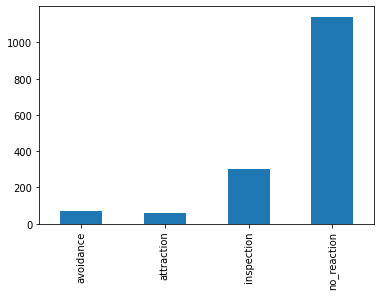

In [9]:
df[df.columns[2:6]].astype(int).sum().plot.bar()

<AxesSubplot:>

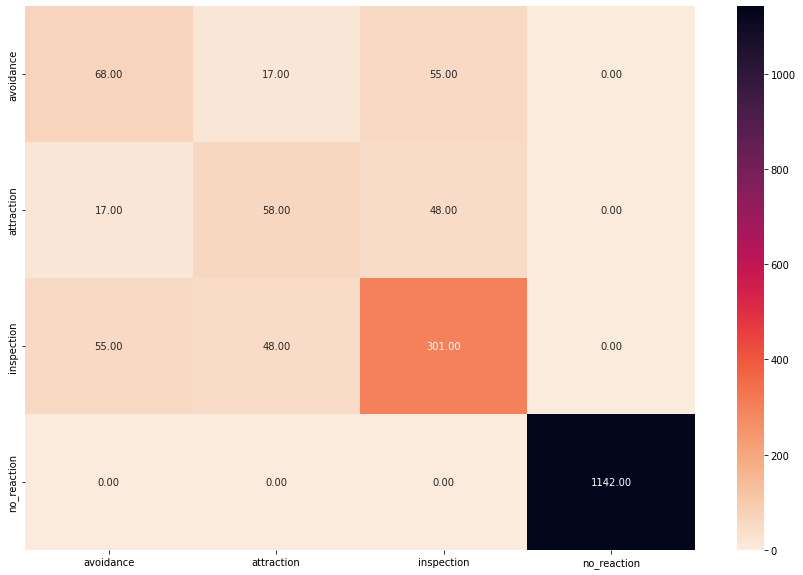

In [10]:
attr = df.columns[2:6]

# Plot co-occurence matrix
coocc_df = df[attr].astype(int)
coocc = coocc_df.T.dot(coocc_df)

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(coocc, cmap="rocket_r", annot=True, fmt=".2f")